In [114]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [115]:
PROCESSED_FEATURES_DIR = "../processed_features"
SEQUENCE_LENGTH = 15  # 时间序列长度(帧数)
BATCH_SIZE = 16
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
CLASS_NAMES = ["awake", "light_drowsy", "severe_drowsy", "distracted"]
NUM_CLASSES = len(CLASS_NAMES)

In [117]:
class SequenceDataset(Dataset):
    """时间序列数据集"""

    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [118]:
class LSTMModel(nn.Module):
    """LSTM分类模型"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM输出
        out, _ = self.lstm(x, (h0, c0))

        # 取最后一个时间步的输出
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [119]:
def load_and_prepare_data(data_dir, seq_length):
    """
    加载并准备时间序列数据

    Returns:
        sequences: (N, seq_length, feature_dim)
        labels: (N,)
    """
    sequences = []
    labels = []

    print("加载特征文件...")
    for filename in tqdm(os.listdir(data_dir)):
        if not filename.endswith(".npy"):
            continue

        # 修改解析逻辑: 处理带下划线的类别名
        # 可能的格式:
        # - awake_A.npy
        # - light_drowsy_A.npy
        # - severe_drowsy_M.npy
        # - distracted_J.npy

        # 移除 .npy 后缀
        name_without_ext = filename[:-4]

        # 尝试匹配类别
        category = None
        for class_name in CLASS_NAMES:
            if name_without_ext.startswith(class_name + "_"):
                category = class_name
                break

        if category is None:
            continue

        label = CLASS_NAMES.index(category)

        # 加载特征
        features = np.load(os.path.join(data_dir, filename))

        # 滑动窗口生成序列
        for i in range(len(features) - seq_length + 1):
            seq = features[i : i + seq_length]
            sequences.append(seq)
            labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    print(f"\n数据加载完成:")
    print(f"序列数量: {len(sequences)}")
    print(f"序列形状: {sequences.shape}")
    print(f"类别分布: {np.bincount(labels)}")

    return sequences, labels

In [120]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 统计
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [121]:
def validate(model, dataloader, criterion, device):
    """验证模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [122]:
def train_model():
    """完整训练流程"""
    print(f"使用设备: {DEVICE}")

    # 1. 加载数据
    sequences, labels = load_and_prepare_data(PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH)

    # 数据标准化
    mean = sequences.mean(axis=(0, 1))
    std = sequences.std(axis=(0, 1)) + 1e-6
    sequences = (sequences - mean) / std

    # 保存标准化参数
    np.save("normalization_params.npy", {"mean": mean, "std": std})

    # 2. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"\n训练集: {len(X_train)}, 测试集: {len(X_test)}")

    # 3. 创建数据加载器
    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 4. 创建模型
    input_size = sequences.shape[2]  # 特征维度
    model = LSTMModel(input_size, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(DEVICE)

    print(f"\n模型结构:")
    print(model)
    print(f"参数量: {sum(p.numel() for p in model.parameters())}")

    # 5. 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # 移除 verbose 参数
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    # 6. 训练
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0

    print(f"\n开始训练...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, DEVICE
        )
        val_loss, val_acc = validate(model, test_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_acc": val_acc,
                    "input_size": input_size,
                    "hidden_size": HIDDEN_SIZE,
                    "num_layers": NUM_LAYERS,
                    "num_classes": NUM_CLASSES,
                },
                "best_lstm_model.pth",
            )
            print(f"  ✓ 保存最佳模型 (Val Acc: {val_acc:.2f}%)")

        # 手动打印学习率变化
        old_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]["lr"]
        if old_lr != new_lr:
            print(f"  学习率调整: {old_lr:.6f} -> {new_lr:.6f}")

    # 7. 绘制训练曲线
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.tight_layout()
    plt.savefig("training_curves.png")
    print(f"\n训练曲线已保存到 training_curves.png")

    return model

In [123]:
def diagnose_data_files():
    """诊断每个数据文件的详细信息"""
    print("=" * 80)
    print("数据文件诊断")
    print("=" * 80)

    category_stats = {
        name: {"files": 0, "total_frames": 0, "valid_sequences": 0, "empty_files": []}
        for name in CLASS_NAMES
    }

    for filename in sorted(os.listdir(PROCESSED_FEATURES_DIR)):
        if not filename.endswith(".npy"):
            continue

        # 修改解析逻辑
        name_without_ext = filename[:-4]

        category = None
        for class_name in CLASS_NAMES:
            if name_without_ext.startswith(class_name + "_"):
                category = class_name
                break

        if category is None:
            print(f"⚠️  跳过未知类别: {filename}")
            continue

        filepath = os.path.join(PROCESSED_FEATURES_DIR, filename)
        features = np.load(filepath)

        category_stats[category]["files"] += 1
        category_stats[category]["total_frames"] += len(features)

        # 计算可生成的序列数
        num_sequences = max(0, len(features) - SEQUENCE_LENGTH + 1)
        category_stats[category]["valid_sequences"] += num_sequences

        # 检查是否为空或帧数不足
        if len(features) == 0:
            category_stats[category]["empty_files"].append(filename)
            print(f"❌ {filename:30s} - 空文件!")
        elif len(features) < SEQUENCE_LENGTH:
            category_stats[category]["empty_files"].append(filename)
            print(f"⚠️  {filename:30s} - 帧数不足: {len(features)} < {SEQUENCE_LENGTH}")
        else:
            # 只显示前20个文件的详细信息,避免输出过多
            if category_stats[category]["files"] <= 20:
                print(
                    f"✓  {filename:40s} - 帧数: {len(features):4d}, 可生成序列: {num_sequences:4d}"
                )

    # 汇总统计
    print("\n" + "=" * 80)
    print("类别统计汇总")
    print("=" * 80)

    for class_name in CLASS_NAMES:
        stats = category_stats[class_name]
        print(f"\n【{class_name}】")
        print(f"  文件数: {stats['files']}")
        print(f"  总帧数: {stats['total_frames']}")
        print(f"  可生成序列数: {stats['valid_sequences']}")
        if stats["empty_files"]:
            print(f"  ⚠️  问题文件 ({len(stats['empty_files'])}个):")
            for f in stats["empty_files"][:5]:  # 只显示前5个
                print(f"      - {f}")
            if len(stats["empty_files"]) > 5:
                print(f"      ... 还有 {len(stats['empty_files']) - 5} 个")

    print("\n" + "=" * 80)

    # 计算总序列数
    total_sequences = sum(s["valid_sequences"] for s in category_stats.values())
    print(f"\n预计总序列数: {total_sequences}")

    # 检查是否可以训练
    min_sequences = min(s["valid_sequences"] for s in category_stats.values())
    print(f"最少序列的类别有: {min_sequences} 个序列")

    if min_sequences < 10:
        print("\n❌ 警告: 某些类别序列数太少,可能无法正常训练!")
        print("   建议: 检查数据预处理脚本或降低 SEQUENCE_LENGTH")
    else:
        print("\n✓ 数据量充足,可以开始训练!")

    return category_stats


diagnose_data_files()

数据文件诊断
✓  awake_A.npy                              - 帧数: 1252, 可生成序列: 1238
✓  awake_A_aug0.npy                         - 帧数: 1252, 可生成序列: 1238
✓  awake_A_aug1.npy                         - 帧数: 1252, 可生成序列: 1238
✓  awake_A_aug2.npy                         - 帧数: 1252, 可生成序列: 1238
✓  awake_C.npy                              - 帧数:  399, 可生成序列:  385
✓  awake_C_aug0.npy                         - 帧数:  399, 可生成序列:  385
✓  awake_C_aug1.npy                         - 帧数:  399, 可生成序列:  385
✓  awake_C_aug2.npy                         - 帧数:  399, 可生成序列:  385
✓  awake_E.npy                              - 帧数: 1000, 可生成序列:  986
✓  awake_E_aug0.npy                         - 帧数: 1000, 可生成序列:  986
✓  awake_E_aug1.npy                         - 帧数: 1000, 可生成序列:  986
✓  awake_E_aug2.npy                         - 帧数: 1000, 可生成序列:  986
✓  awake_G.npy                              - 帧数:  109, 可生成序列:   95
✓  awake_G_aug0.npy                         - 帧数:  109, 可生成序列:   95
✓  awake_G_aug1.npy                      

{'awake': {'files': 100,
  'total_frames': 70909,
  'valid_sequences': 69509,
  'empty_files': []},
 'light_drowsy': {'files': 100,
  'total_frames': 77780,
  'valid_sequences': 76380,
  'empty_files': []},
 'severe_drowsy': {'files': 100,
  'total_frames': 100295,
  'valid_sequences': 98895,
  'empty_files': []},
 'distracted': {'files': 100,
  'total_frames': 76634,
  'valid_sequences': 75234,
  'empty_files': []}}

In [124]:
def test_model(model_path="best_lstm_model.pth"):
    """测试模型并计算详细指标"""
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    # 加载模型
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model = LSTMModel(
        checkpoint["input_size"],
        checkpoint["hidden_size"],
        checkpoint["num_layers"],
        checkpoint["num_classes"],
    ).to(DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    print(f"加载模型: {model_path}")
    print(f"验证准确率: {checkpoint['val_acc']:.2f}%")

    # 加载测试数据
    sequences, labels = load_and_prepare_data(PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH)

    # 标准化
    norm_params = np.load("normalization_params.npy", allow_pickle=True).item()
    sequences = (sequences - norm_params["mean"]) / norm_params["std"]

    # 划分测试集
    _, X_test, _, y_test = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    test_dataset = SequenceDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 预测
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(DEVICE)
            outputs = model(sequences)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    # 分类报告
    print("\n分类报告:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    print("混淆矩阵已保存到 confusion_matrix.png")

    return all_preds, all_labels, all_probs

使用设备: cuda
加载特征文件...


100%|██████████| 400/400 [00:00<00:00, 2562.13it/s]



数据加载完成:
序列数量: 320018
序列形状: (320018, 15, 7)
类别分布: [69509 76380 98895 75234]

训练集: 256014, 测试集: 64004

模型结构:
LSTMModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
参数量: 52228

开始训练...
Epoch [1/10]
  Train Loss: 0.1383, Train Acc: 94.49%
  Val Loss: 0.0430, Val Acc: 98.36%
  ✓ 保存最佳模型 (Val Acc: 98.36%)
Epoch [2/10]
  Train Loss: 0.0408, Train Acc: 98.52%
  Val Loss: 0.0274, Val Acc: 98.97%
  ✓ 保存最佳模型 (Val Acc: 98.97%)
Epoch [3/10]
  Train Loss: 0.0253, Train Acc: 99.14%
  Val Loss: 0.0126, Val Acc: 99.58%
  ✓ 保存最佳模型 (Val Acc: 99.58%)
Epoch [4/10]
  Train Loss: 0.0179, Train Acc: 99.42%
  Val Loss: 0.0102, Val Acc: 99.64%
  ✓ 保存最佳模型 (Val Acc: 99.64%)
Epoch [5/10]
  Train Loss: 0.0143, Train Acc: 99.54%
  Val Loss: 0.0116, Val Acc: 99.56%
Epoch [6/10]
  Train Loss: 0.0112, Train Acc: 99.66%
  Val Loss: 0.0071, Val Acc: 99.77%
  ✓ 保存最佳模型 (Val Acc: 99.77%)
Epoch [7/10]

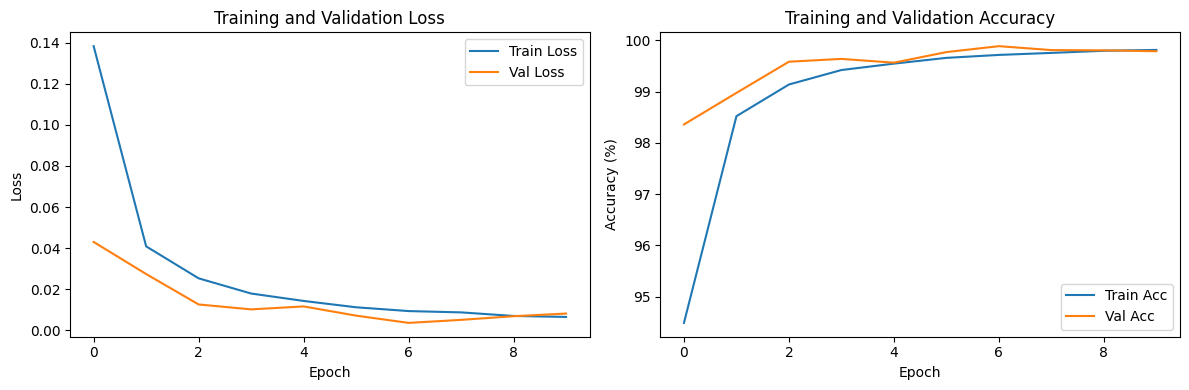

In [125]:
model = train_model()

加载模型: best_lstm_model.pth
验证准确率: 99.88%
加载特征文件...


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 2546.64it/s]



数据加载完成:
序列数量: 320018
序列形状: (320018, 15, 7)
类别分布: [69509 76380 98895 75234]

分类报告:
               precision    recall  f1-score   support

        awake       1.00      1.00      1.00     13902
 light_drowsy       1.00      1.00      1.00     15276
severe_drowsy       1.00      1.00      1.00     19779
   distracted       1.00      1.00      1.00     15047

     accuracy                           1.00     64004
    macro avg       1.00      1.00      1.00     64004
 weighted avg       1.00      1.00      1.00     64004

混淆矩阵已保存到 confusion_matrix.png


([3,
  0,
  1,
  1,
  2,
  1,
  2,
  1,
  3,
  0,
  0,
  2,
  3,
  1,
  3,
  2,
  1,
  2,
  0,
  1,
  3,
  2,
  2,
  0,
  3,
  2,
  3,
  2,
  0,
  0,
  0,
  2,
  3,
  2,
  1,
  1,
  3,
  3,
  1,
  3,
  1,
  3,
  1,
  1,
  0,
  0,
  1,
  2,
  3,
  0,
  3,
  0,
  2,
  0,
  1,
  2,
  3,
  2,
  0,
  3,
  0,
  1,
  2,
  3,
  1,
  2,
  1,
  1,
  0,
  3,
  0,
  2,
  1,
  2,
  1,
  2,
  3,
  2,
  3,
  1,
  3,
  1,
  1,
  2,
  0,
  1,
  2,
  0,
  0,
  0,
  2,
  2,
  3,
  2,
  3,
  2,
  3,
  0,
  2,
  2,
  0,
  1,
  3,
  2,
  1,
  1,
  3,
  0,
  3,
  0,
  2,
  3,
  1,
  2,
  3,
  3,
  2,
  3,
  3,
  2,
  3,
  1,
  1,
  0,
  2,
  1,
  3,
  3,
  3,
  2,
  2,
  0,
  3,
  3,
  1,
  3,
  1,
  2,
  1,
  1,
  2,
  2,
  3,
  0,
  3,
  2,
  3,
  3,
  0,
  2,
  0,
  1,
  0,
  0,
  3,
  0,
  2,
  0,
  0,
  1,
  1,
  1,
  2,
  1,
  2,
  2,
  2,
  3,
  1,
  2,
  2,
  0,
  2,
  1,
  3,
  0,
  3,
  1,
  1,
  3,
  2,
  3,
  0,
  2,
  1,
  2,
  1,
  3,
  2,
  1,
  2,
  2,
  3,
  2,
  2,
  1,
  1,
  0,
  3,
  2,


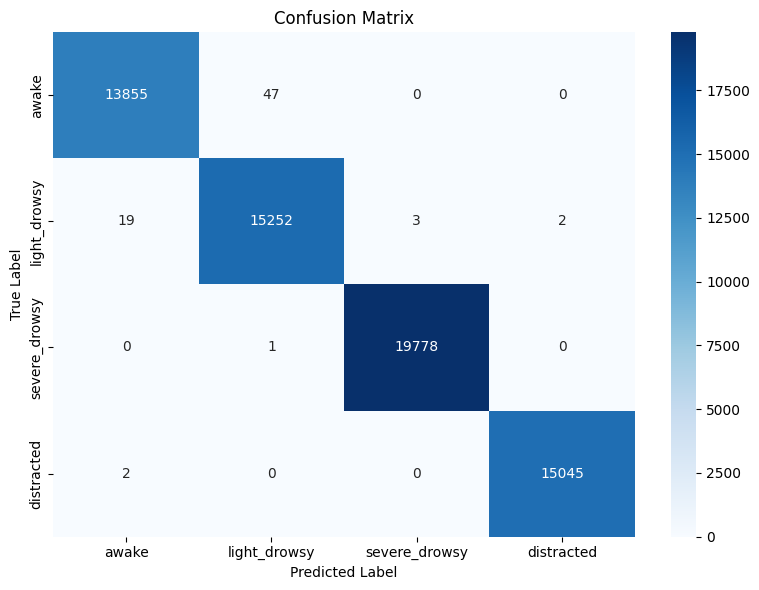

In [126]:
test_model()